In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.dummy  import DummyClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report, roc_auc_score,roc_curve,f1_score,accuracy_score,r2_score
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance
import json
import joblib

import os
os.makedirs('artifacts/figures', exist_ok=True)

In [39]:
df = pd.read_csv("S06-hw-dataset-04.csv")
df.describe()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,...,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
mean,12500.500000,-0.000386,-0.004872,0.003202,0.335329,-0.000563,-0.010118,0.001182,0.957385,-0.004658,...,-0.166251,-3.387506,1.749793,-0.013017,-0.001383,0.893365,-0.909479,0.000570,-0.000754,0.04920
std,7217.022701,1.001623,0.995606,1.004367,3.207537,0.993965,1.002172,2.432162,1.830223,1.013470,...,4.234741,4.331576,5.318660,1.001594,0.996409,2.445185,1.962618,0.994320,0.997167,0.21629
min,1.000000,-4.370993,-4.087073,-4.103875,-13.249937,-4.118778,-3.895974,-8.883224,-8.132548,-4.068933,...,-20.021141,-18.332290,-20.336666,-4.349216,-4.119472,-9.508509,-7.919287,-4.038312,-3.812255,0.00000
25%,6250.750000,-0.680165,-0.675100,-0.675426,-1.750048,-0.669764,-0.674374,-1.647977,-0.217260,-0.688278,...,-2.897904,-6.278403,-1.775889,-0.689962,-0.676191,-0.735473,-2.226959,-0.666367,-0.665861,0.00000
50%,12500.500000,0.001859,-0.000247,0.013272,0.403483,-0.001309,-0.005994,-0.011349,0.963009,0.000414,...,-0.396946,-3.462072,1.931851,-0.020933,-0.004193,0.888535,-0.923354,0.004381,0.002420,0.00000
75%,18750.250000,0.679702,0.659523,0.683437,2.486453,0.672299,0.652629,1.658680,2.167758,0.681040,...,2.344956,-0.578540,5.473886,0.661300,0.673722,2.516790,0.395648,0.666474,0.665918,0.00000
max,25000.000000,4.208888,3.984564,3.793442,15.288250,4.020733,4.279607,9.538525,9.321099,4.261349,...,20.717964,18.818764,20.688069,4.338337,3.902131,11.880651,6.778980,3.834922,4.012639,1.00000


In [40]:
#распределение таргета
df["target"].value_counts(normalize=True)

target
0    0.9508
1    0.0492
Name: proportion, dtype: float64

In [41]:
#Проверка на пропуски
df.isna().sum()

id        0
f01       0
f02       0
f03       0
f04       0
         ..
f57       0
f58       0
f59       0
f60       0
target    0
Length: 62, dtype: int64

In [42]:
X = df.drop(columns=["id","target"])
y = df["target"]

X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.25,stratify=y,random_state=42)
#В данном случае random_state важен для возпроизводимости результатов, а stratify важен чтобы 
# распределение в обучающей и тестовой выборке были одинаковы (особенно при таком дисбалансе классов)

In [43]:
def save_metrics_to_json(y_pred,y_proba,label):
    dict_metrics = {}
    for i in range(len(label)):
        dict_metrics[label[i]] = {}
        dict_metrics[label[i]]["f1"] = f1_score(y_true=y_test,y_pred=y_pred[i])
        dict_metrics[label[i]]["roc_auc"] = roc_auc_score(y_true=y_test,y_score=y_proba[i])
        dict_metrics[label[i]]["accuracy_score"] = accuracy_score(y_true=y_test,y_pred=y_pred[i])
        dict_metrics[label[i]]["r2"] = r2_score(y_true=y_test,y_pred=y_pred[i])
    with open('artifacts/metrics_test.json', 'w', encoding='utf-8') as f:
        json.dump(dict_metrics, f, ensure_ascii=False, indent=4)
        

        
def comparison_models(y_pred,y_proba,label):
    plt.figure(figsize=(8, 6))
    for i in range(len(y_pred)):
        fpr, tpr, _ = roc_curve(y_test, y_proba[i])
        plt.plot(fpr, tpr, lw=2, label=label[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайный классификатор')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc="lower right")
    plt.savefig("artifacts/figures/roc_auc_all")
    plt.show()
    for i in range(len(y_pred)):
        print(f'---------------------{label[i]}---------------------')
        print(classification_report(y_true=y_test,y_pred=y_pred[i]))
        print(f"ROC-AUC: {roc_auc_score(y_true=y_test,y_score=y_proba[i])}")
    save_metrics_to_json(y_pred,y_proba,label)

classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight='balanced', 
    classes=classes, 
    y=y_train
)

class_weights_dict = dict(zip(classes, weights))

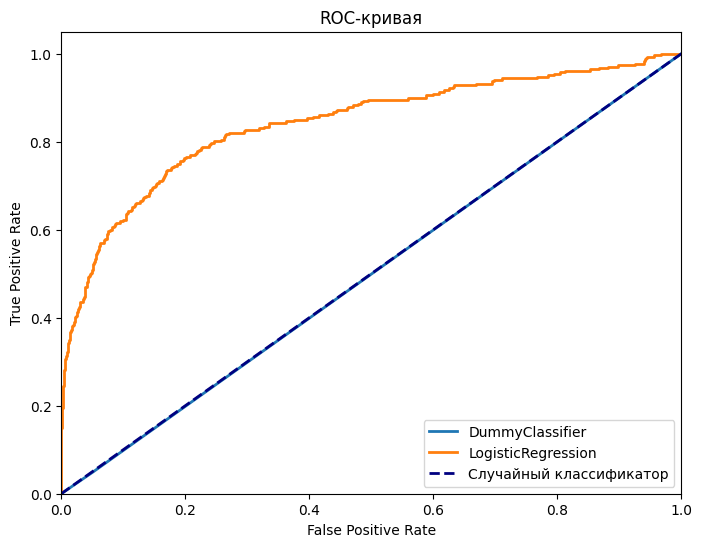

---------------------DummyClassifier---------------------
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5943
           1       0.05      0.05      0.05       307

    accuracy                           0.91      6250
   macro avg       0.50      0.50      0.50      6250
weighted avg       0.91      0.91      0.91      6250

ROC-AUC: 0.499106056943789
---------------------LogisticRegression---------------------
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      5943
           1       0.15      0.78      0.26       307

    accuracy                           0.78      6250
   macro avg       0.57      0.78      0.56      6250
weighted avg       0.94      0.78      0.84      6250

ROC-AUC: 0.8418608704517014


In [44]:
#Наши бэйзлайны будут такими
dmn = DummyClassifier(strategy="stratified",random_state=42)
dmn.fit(X_train,y_train)
y_pred_dmn = dmn.predict(X_test)
y_proba_dmn = dmn.predict_proba(X_test)[:,1]

lr_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),    
    ('classifier', LogisticRegression(
                    class_weight=class_weights_dict,
                    penalty='l2',
                    random_state=42
                    )) 
])
lr_pipeline.fit(X_train,y_train)
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:,1]

y_pred_list = [y_pred_dmn,y_pred_lr]
y_proba_list = [y_proba_dmn,y_proba_lr]
labels  = ["DummyClassifier","LogisticRegression"]
comparison_models(y_pred_list,y_proba_list,labels)

Как видим DummyClassifier работает действительно как модель которая просто пытается повторить распределение таргета, но у неё отсутствует обобщающая способность, поэтому у неё ROC-AUC 0.5
Обучим логистическую регрессию мы видим что ROC-AUC стал гораздо лучше и стал 0.84

In [45]:
dtc = DecisionTreeClassifier(criterion="gini",max_depth=16,min_samples_leaf=10,random_state=42,class_weight=class_weights_dict)
dtc.fit(X_train,y_train)
y_pred_dtc = dtc.predict(X_test)
y_proba_dtc = dtc.predict_proba(X_test)[:,1]

rfc = RandomForestClassifier(n_estimators=1000,criterion="gini",max_depth=16,random_state=42,class_weight=class_weights_dict)
rfc.fit(X_train,y_train)
y_pred_rfc = rfc.predict(X_test)
y_proba_rfc = rfc.predict_proba(X_test)[:,1]

gbc = GradientBoostingClassifier(loss="log_loss",learning_rate=0.01,n_estimators=1000,min_samples_leaf=10,max_depth=3,random_state=42)
gbc.fit(X_train,y_train)
y_pred_gbc = gbc.predict(X_test)
y_proba_gbc = gbc.predict_proba(X_test)[:,1]

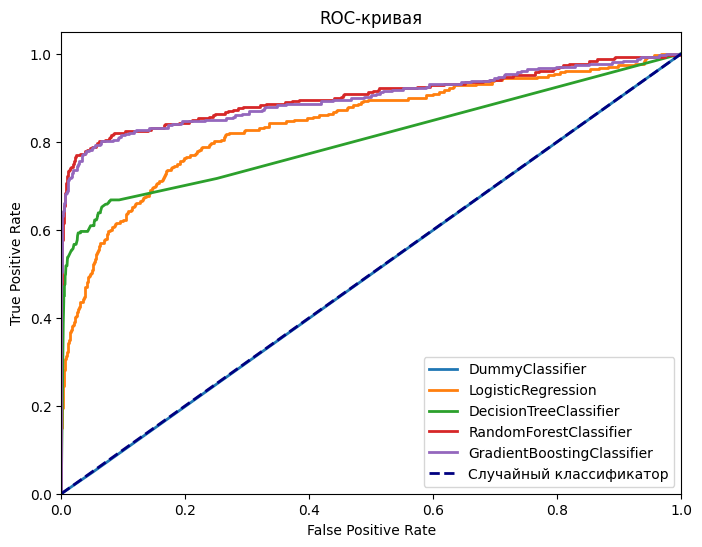

---------------------DummyClassifier---------------------
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5943
           1       0.05      0.05      0.05       307

    accuracy                           0.91      6250
   macro avg       0.50      0.50      0.50      6250
weighted avg       0.91      0.91      0.91      6250

ROC-AUC: 0.499106056943789
---------------------LogisticRegression---------------------
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      5943
           1       0.15      0.78      0.26       307

    accuracy                           0.78      6250
   macro avg       0.57      0.78      0.56      6250
weighted avg       0.94      0.78      0.84      6250

ROC-AUC: 0.8418608704517014
---------------------DecisionTreeClassifier---------------------
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      594

In [46]:
y_pred_list.extend([y_pred_dtc,y_pred_rfc,y_pred_gbc])
y_proba_list.extend([y_proba_dtc,y_proba_rfc,y_proba_gbc])
labels.extend(["DecisionTreeClassifier","RandomForestClassifier","GradientBoostingClassifier"])
comparison_models(y_pred_list,y_proba_list,labels)

In [47]:
estimators = [
    ('rf',RandomForestClassifier(n_estimators=1000,criterion="gini",max_depth=16,random_state=42,class_weight=class_weights_dict)),
    ('gb',GradientBoostingClassifier(loss="log_loss",learning_rate=0.1,n_estimators=1000,min_samples_leaf=10,max_depth=3,random_state=42)),
    ('lr', Pipeline(steps=[
            ('scaler', StandardScaler()),    
            ('classifier', LogisticRegression(
                            class_weight=class_weights_dict,
                            penalty='l2',
                            random_state=42
                            )) 
        ]))]

final_est = LogisticRegression(max_iter=2000)

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=final_est,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

stacking_clf.fit(X_train, y_train)

y_pred_stack = stacking_clf.predict(X_test)
y_proba_stack = stacking_clf.predict_proba(X_test)[:, 1]

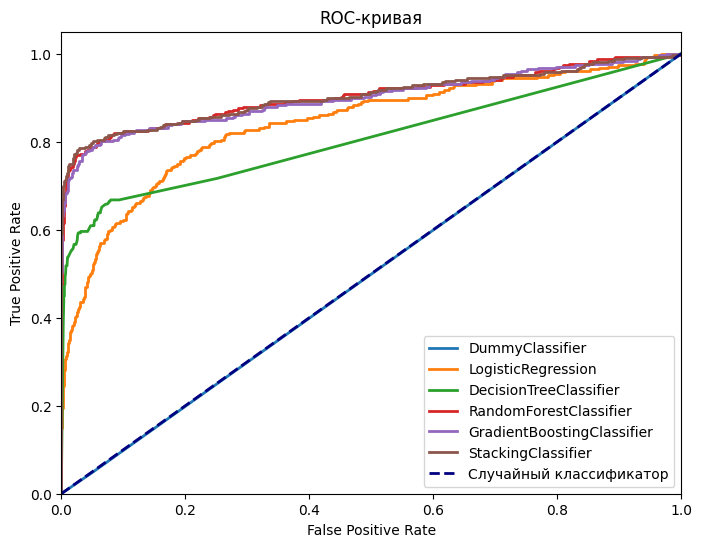

---------------------DummyClassifier---------------------
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5943
           1       0.05      0.05      0.05       307

    accuracy                           0.91      6250
   macro avg       0.50      0.50      0.50      6250
weighted avg       0.91      0.91      0.91      6250

ROC-AUC: 0.499106056943789
---------------------LogisticRegression---------------------
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      5943
           1       0.15      0.78      0.26       307

    accuracy                           0.78      6250
   macro avg       0.57      0.78      0.56      6250
weighted avg       0.94      0.78      0.84      6250

ROC-AUC: 0.8418608704517014
---------------------DecisionTreeClassifier---------------------
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      594

In [48]:
y_pred_list.append(y_pred_stack)
y_proba_list.append(y_proba_stack)
labels.append("StackingClassifier")
comparison_models(y_pred_list,y_proba_list,labels)

In [49]:
permutation_importance = permutation_importance(
    estimator=stacking_clf,
    X = X_test,
    y = y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc"
)

feature_names = [f"Feature_{i}" for i in range(X_test.shape[1])]
results = []
for i in range(len(feature_names)):
    results.append({
        'feature': feature_names[i],
        'importance_mean': permutation_importance.importances_mean[i],
        'importance_std': permutation_importance.importances_std[i]
    })

results_sorted = sorted(results, key=lambda x: x['importance_mean'], reverse=True)

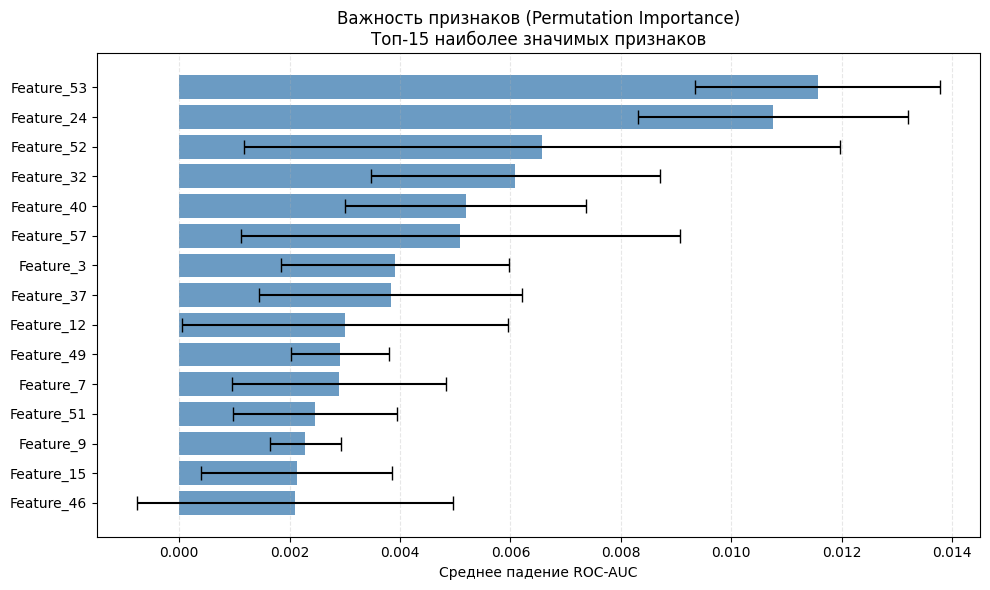

In [50]:
top_n = 15
top_features = results_sorted[:top_n]

features = [res['feature'] for res in top_features]
importances = [res['importance_mean'] for res in top_features]
errors = [res['importance_std'] for res in top_features]

plt.figure(figsize=(10, 6))
y_pos = np.arange(len(features))

plt.barh(y_pos, importances, xerr=errors, 
         color='steelblue', alpha=0.8, capsize=5)

plt.yticks(y_pos, features)
plt.xlabel('Среднее падение ROC-AUC')
plt.title(f'Важность признаков (Permutation Importance)\nТоп-{top_n} наиболее значимых признаков')
plt.gca().invert_yaxis()  
plt.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig("artifacts/figures/feature_importance")
plt.show()

In [51]:
gb = GradientBoostingClassifier(random_state=42)

param_grid_gb = {
    'n_estimators': [100, 300, 500], 
    'max_depth': [3, 5, 7],
}

grid_search_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid_gb,  
    cv=3,  
    scoring='roc_auc',
    n_jobs=-1,
    verbose=10,
    return_train_score=True,
    refit=True 
)

grid_search_gb.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


,estimator,GradientBoost...ndom_state=42)
,param_grid,"{'max_depth': [3, 5, ...], 'n_estimators': [100, 300, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,10
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,loss,'log_loss'


In [52]:
best_model = grid_search_gb.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
print(classification_report(y_true=y_test,y_pred=y_pred))
test_roc_auc

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5943
           1       0.93      0.61      0.73       307

    accuracy                           0.98      6250
   macro avg       0.95      0.80      0.86      6250
weighted avg       0.98      0.98      0.98      6250



0.9010195116363322

In [53]:
search_summaries = {}
search_summaries["GradientBoostingClassifier"] = grid_search_gb.best_params_
with open("artifacts/search_summaries.json","w") as file:
    json.dump(search_summaries, file, ensure_ascii=False, indent=4)

Если смотреть по ROC-AUC, то StackingClassifier обучился лучше всего, он выдал 0.904

In [ ]:
joblib.dump(stacking_clf, 'artifacts/best_model.joblib ')

accuracy = accuracy_score(y_test, y_pred_stack)
roc_auc = roc_auc_score(y_test, y_proba_stack)
f1 = f1_score(y_test, y_pred_stack)

metadata = {
    "model_name": "StackingClassifier",
    "best_model": "Stacking ensemble",
    "parameters": {
        "base_estimators": ["RandomForest", "GradientBoosting", "LogisticRegression"],
        "final_estimator": "LogisticRegression",
        "cv_folds": 5,
        "passthrough": False
    },
    "test_metrics": {
        "accuracy": round(float(accuracy), 4),
        "roc_auc": round(float(roc_auc), 4),
        "f1_score": round(float(f1), 4)
    },
    "training_info": {
        "train_samples": int(X_train.shape[0]),
        "test_samples": int(X_test.shape[0]),
        "features": int(X_train.shape[1])
    },
    "base_models_params": {
        "RandomForest": {
            "n_estimators": 1000,
            "max_depth": 16,
            "class_weight": "balanced_dict"
        },
        "GradientBoosting": {
            "n_estimators": 1000,
            "learning_rate": 0.1,
            "max_depth": 3
        },
        "LogisticRegression": {
            "penalty": "l2",
            "class_weight": "balanced_dict"
        }
    }
}

with open('artifacts/best_model_meta.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)